# **Import Libraries**

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# **Extract Image Features**

In [3]:
model = InceptionV3(weights='imagenet')

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [4]:
# Directory containing images
directory = os.path.join(BASE_DIR, 'Images')

In [5]:
# Initialize a dictionary to store the sizes of images
image_sizes = {}

# Iterate through each image in the directory to check sizes
for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    
    # Open the image and get its size
    with Image.open(img_path) as img:
        width, height = img.size
        image_sizes[img_name] = (width, height)
        print(f'{img_name}: {width}x{height}')

  0%|          | 0/8091 [00:00<?, ?it/s]

3226254560_2f8ac147ea.jpg: 500x333
214543992_ce6c0d9f9b.jpg: 500x500
2366643786_9c9a830db8.jpg: 500x375
3368819708_0bfa0808f8.jpg: 500x333
2190227737_6e0bde2623.jpg: 281x500
2752809449_632cd991b3.jpg: 334x500
3097776588_312932e438.jpg: 374x500
1206506157_c7956accd5.jpg: 500x334
1319634306_816f21677f.jpg: 500x333
2465218087_fca77998c6.jpg: 500x337
3351493005_6e5030f596.jpg: 500x473
2949337912_beba55698b.jpg: 500x187
534886684_a6c9f40fa1.jpg: 500x333
3543600125_223747ef4c.jpg: 500x375
2174206711_11cb712a8d.jpg: 500x308
280706862_14c30d734a.jpg: 500x357
2100735137_05c6079537.jpg: 500x375
3131632154_098f86f4cb.jpg: 500x333
2236016316_f476cbbf06.jpg: 500x333
3335375223_b4da8df523.jpg: 500x375
929679367_ff8c7df2ee.jpg: 375x500
241347214_5f19e7998c.jpg: 333x500
2998024845_1529c11694.jpg: 333x500
1317292658_ba29330a0b.jpg: 334x500
2521938720_911ac092f7.jpg: 500x414
3426933951_2302a941d8.jpg: 500x299
2410399168_1462c422d4.jpg: 500x332
2587106431_1cc0e719c6.jpg: 500x334
2339516180_12493e8ecf.jpg

In [6]:
# extract features from image
features = {}

for img_name in tqdm(os.listdir(directory)):
    # img_path = os.path.join(directory, img_name)
    img_path = directory + '/' + img_name
    
    # image = load_img(img_path, target_size=(224, 224))
    # Load image and resize to 299x299 (required input size for InceptionV3)
    image = load_img(img_path, target_size=(299, 299))
    
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1729099163.996922      96 service.cc:145] XLA service 0x7f98dc004520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729099163.996977      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729099169.060149      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
# # Save the tokenizer
# with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
#     pickle.dump(tokenizer, f)

# Save the feature extractor (e.g., InceptionV3)
with open(os.path.join(WORKING_DIR, 'feature_extractor.pkl'), 'wb') as f:
    pickle.dump(model, f)  # Assuming model is your feature extractor

print("Model, tokenizer, and feature extractor saved successfully.")

Model, tokenizer, and feature extractor saved successfully.


# **Load the Captions Data**

In [8]:
# store the captions data from the text file
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

# **Preprocess Text Data**

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower() 
            
            caption = caption.replace('[^A-Za-z]', '')
            # caption = re.sub(r'[^A-Za-z]', '', caption)
            
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            
            captions[i] = caption    #update

In [12]:
# before
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
clean(mapping)

In [14]:
# after
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
# store final captions in list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
file_path = '/kaggle/working/captions.txt'

# Write the captions to the file
with open(file_path, 'w') as file:
    for caption in all_captions:
        file.write(caption + '\n')
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
import pickle , os
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)

In [20]:
# # Save the InceptionV3 feature extractor (used to extract image features)
# with open("saved_model/,"feature_extractor.pkl", "wb") as f:
#     pickle.dump(model, f)

In [21]:
vocab_size     # no of unique words

8485

In [22]:
# get it to make suitable padding
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# **Train Test Split**

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)    # 90 --> train & 10 --> test

# slicing (train set / test set)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    '''
    keys: images to process
    mapping: key and value
    features: from inception model
    tokenizer: to convert text to seq. of integers
    '''
    X1, X2, y = list(), list(), list()
    '''
    x1: image features
    x2: array of words
    y: one hot encoded
    '''
    n = 0            # to keep track of number of samples in each batch
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# **Model Creation**

In [25]:
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)
model.summary() 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 35)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 2048)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,172,160 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  2,180,645 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,468,453 (20.86 MB)

 Trainable params: 5,468,453 (20.86 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 235ms/step - loss: 5.9750
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 4.1587
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - loss: 3.6877
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - loss: 3.4220
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - loss: 3.2416
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - loss: 3.1014
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - loss: 2.9857
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - loss: 2.8840
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 2.8061
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - loss: 2.7340
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - loss: 2.6698
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 235ms/step - loss: 2.6066
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 2.5509
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 2.5072
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - loss: 2.4568
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 236ms/step - loss: 2.4141
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - loss: 2.37

In [27]:
model.save(WORKING_DIR+'/best_model.h5')

# **Generate Captions for the Image**

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

# **Validation and Visualization**

In [30]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.375000
BLEU-2: 0.158114


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.480000
BLEU-2: 0.288926
BLEU-1: 0.488372
BLEU-2: 0.312529
BLEU-1: 0.440678
BLEU-2: 0.253177
BLEU-1: 0.410959
BLEU-2: 0.219882
BLEU-1: 0.457831
BLEU-2: 0.278022
BLEU-1: 0.451613
BLEU-2: 0.271143
BLEU-1: 0.446602
BLEU-2: 0.265549
BLEU-1: 0.442478
BLEU-2: 0.260909
BLEU-1: 0.467213
BLEU-2: 0.281530
BLEU-1: 0.485075
BLEU-2: 0.294553
BLEU-1: 0.493243
BLEU-2: 0.295030
BLEU-1: 0.493506
BLEU-2: 0.289829
BLEU-1: 0.473684
BLEU-2: 0.269092
BLEU-1: 0.470270
BLEU-2: 0.262978
BLEU-1: 0.464646
BLEU-2: 0.262547
BLEU-1: 0.483254
BLEU-2: 0.265470
BLEU-1: 0.493151
BLEU-2: 0.280199
BLEU-1: 0.495726
BLEU-2: 0.279989
BLEU-1: 0.502041
BLEU-2: 0.291186
BLEU-1: 0.500000
BLEU-2: 0.286842
BLEU-1: 0.503788
BLEU-2: 0.288567
BLEU-1: 0.518116
BLEU-2: 0.310243
BLEU-1: 0.522968
BLEU-2: 0.314547
BLEU-1: 0.530405
BLEU-2: 0.325099
BLEU-1: 0.537705
BLEU-2: 0.334337
BLEU-1: 0.531646
BLEU-2: 0.326645
BLEU-1: 0.536585
BLEU-2: 0.338336
BLEU-1: 0.530612
BLEU-2: 0.328862
BLEU-1: 0.532394
BLEU-2: 0.328812
BLEU-1: 0.5258

In [31]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black dog is playing with red ball endseq


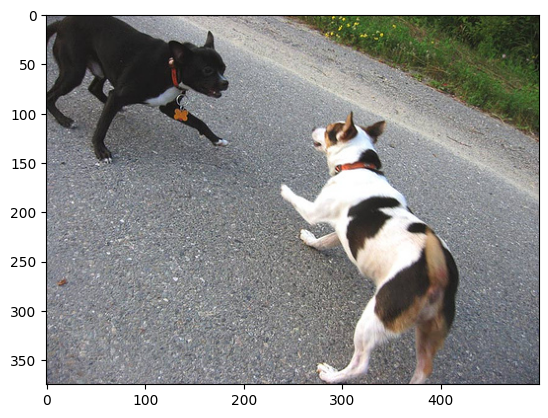

In [32]:
generate_caption("1001773457_577c3a7d70.jpg")

In [33]:
model.save('best.keras')


In [34]:
!pip install fastapi pillow uvicorn nltk 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [35]:
# choose random 3 images to get the captions of them

images_path = os.listdir(os.path.join(BASE_DIR,'Images'))
image_name_idx = np.random.randint(0,8000,3)

print(len(images_path))


8091


<div style = 'border : 3px solid #cde3ea; background-color:#cde3ea;padding:10px; border-radius: 25px;'>



🔘**BLIP (Bootstrapping Language-Image Pretraining)** is a state-of-the-art model designed to bridge the gap between visual and textual data. It utilizes a combination of vision and language processing techniques to generate captions for images, making it particularly effective for tasks like image captioning and visual question answering.

    

    

🔘 **Why BLIP** :  

    

   - **Multi-modal Learning** : BLIP is trained on a large dataset containing both images and their corresponding textual descriptions, enabling it to learn the relationships between visual and linguistic elements.

    

   - **Bootstrapping Mechanism** : The model incorporates a bootstrapping approach, which allows it to refine its understanding of both modalities by leveraging the interactions between them during training. This iterative refinement process enhances the model's performance on various tasks.

    

   - **Transformer Architecture** : BLIP employs a transformer-based architecture, which has become the standard for many natural language processing and computer vision tasks. This architecture allows the model to capture complex dependencies and contextual information effectively.

    

   - **lexible Applications** : Beyond image captioning, BLIP can be adapted for various applications, including visual question answering, where it can answer questions about images, and other multi-modal tasks that require an understanding of both text and images.

    

   - **Hugging Face Integration** : BLIP is available through the Hugging Face Transformers library, making it accessible for developers and researchers to implement and experiment with this powerful model in their projects.  

<a id="8"></a>

# <p style="padding:10px;background-color:#adc6cd ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Image Captioning with BLIP and Transformers 🤖</p>


In [36]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load the BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


BLIP Caption: a little girl sitting at a table


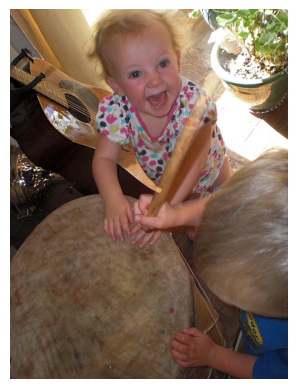

----------
BLIP Caption: a woman and a child playing with a frc


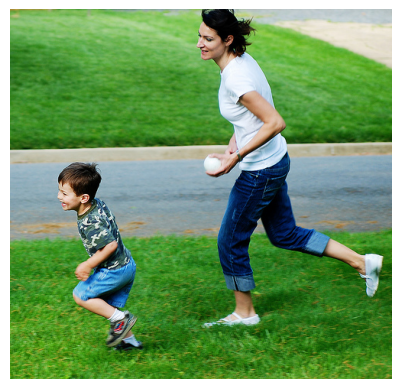

----------
BLIP Caption: a girl standing in front of a large american flag


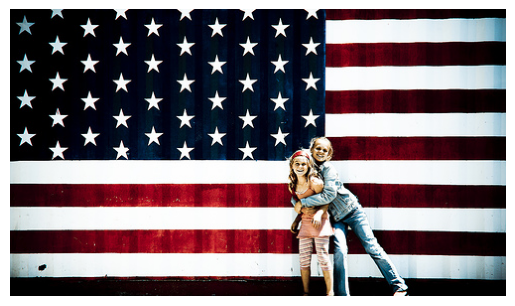

----------


In [37]:
for i in image_name_idx:

    # Load and process the image
    image = Image.open(os.path.join(BASE_DIR,'Images',images_path[i]))
    inputs = processor(image, return_tensors="pt")

    # Generate caption
    output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)
    print("BLIP Caption:", caption)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print('----------')

In [38]:
print(len(all_captions))

40455


Image: 2089555297_95cf001fa7
Actual Caption: ['startseq man in hat with long sleeves and long pants stands overlooking city endseq', 'startseq man stands on cliff overlooking city endseq', 'startseq man with backpack and hat is standing by high cliff where you can see for miles endseq', 'startseq hiker standing on top of rock overlooking town endseq', 'startseq "the man wearing backpack and hat stands on ledge overlooking city ." endseq']
Generated Caption: a man standing on a rock


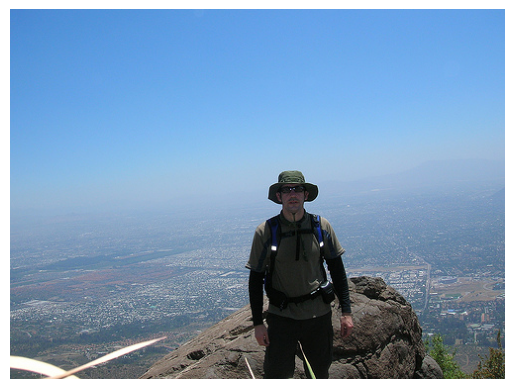

BLEU-1: 0.4777, BLEU-2: 0.2616
----------
Image: 2775744946_1ab5d500a2
Actual Caption: ['startseq child in blue shirt and orange swim trunks is underwater endseq', 'startseq child smiling at the camera while swimming underwater endseq', 'startseq child swims underwater in pool endseq', 'startseq red haired girl in blue t-shirt is swimming underwater in pool endseq', 'startseq child dressed in blue is smiling underwater endseq']
Generated Caption: a boy swimming in a pool


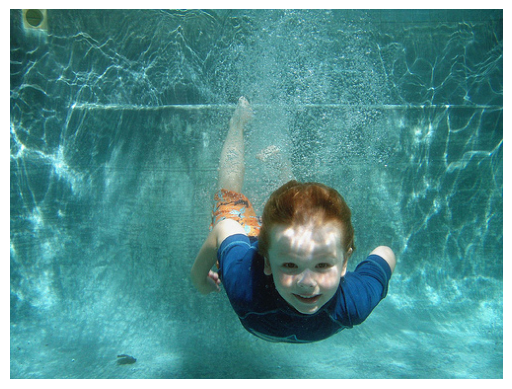

BLEU-1: 0.4232, BLEU-2: 0.0846
----------
Image: 3597146852_3d000a5d5f
Actual Caption: ['startseq boy is doing skateboarding trick in the air endseq', 'startseq boy jumps high above his skateboard near sign endseq', 'startseq boy jumping skateboard beside sign and pink flowers endseq', 'startseq he is skateboarding endseq', 'startseq the boy in black is skateboarding in the air in front of the flowers and white and blue sign endseq']
Generated Caption: a man doing a trick on a skateboard


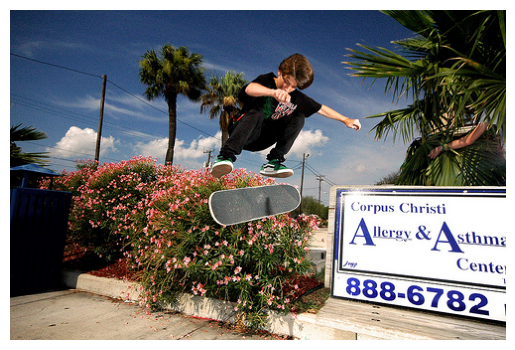

BLEU-1: 0.2921, BLEU-2: 0.0570
----------
Image: 215214751_e913b6ff09
Actual Caption: ['startseq boat with two fishermen sits peacefully on the lake endseq', 'startseq silhouette of two men in boat on misty lake endseq', 'startseq two men in fishing boat on river enjoy pleasant morning endseq', 'startseq two people are in canoe on river in misty conditions endseq', 'startseq two people drift in small boat on foggy lake with trees in the background endseq']
Generated Caption: a body of water


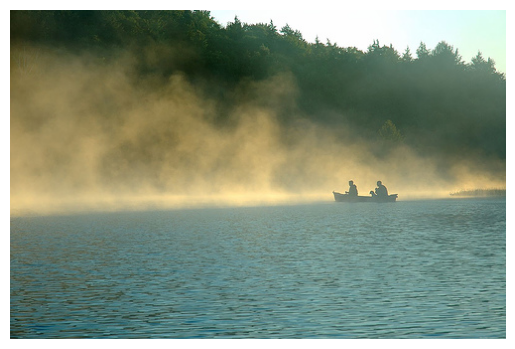

BLEU-1: 0.0434, BLEU-2: 0.0159
----------
Image: 3510218982_318f738b76
Actual Caption: ['startseq boxer is practicing making hits by targeting the gloves of his partner endseq', 'startseq man practices boxing endseq', 'startseq man practicing boxing endseq', 'startseq man with blue boxing gloves is throwing punches endseq', 'startseq an older man in boxing gloves trains endseq']
Generated Caption: a man wearing a gray shirt


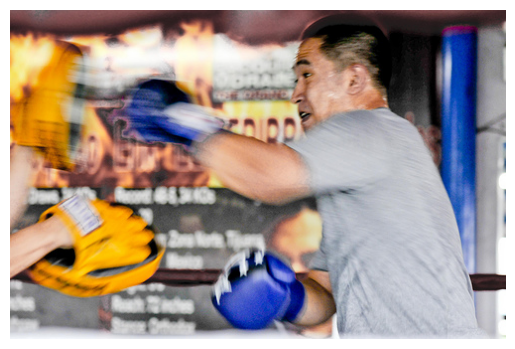

BLEU-1: 0.1667, BLEU-2: 0.0577
----------
Image: 108899015_bf36131a57
Actual Caption: ['startseq lone skier is making their way up mountain endseq', 'startseq skiiers at the top of snow covered hill endseq', 'startseq two hikers climbing snowy hill endseq', 'startseq two people are on snow-covered mountain endseq', 'startseq two people climbing up snowy mountain endseq']
Generated Caption: a clear blue sky


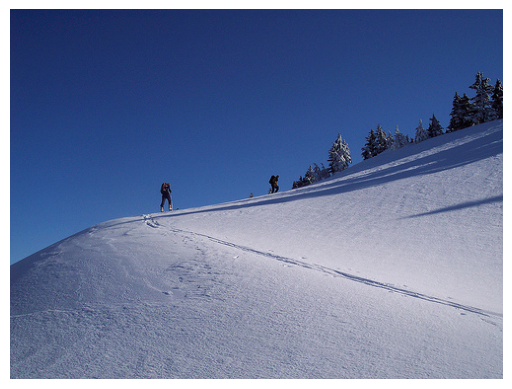

BLEU-1: 0.0000, BLEU-2: 0.0000
----------
Image: 2701487024_e866eb4550
Actual Caption: ['startseq boy plays in the ocean with boogie board endseq', 'startseq an excited boy playing in the surf with body board endseq', 'startseq smiling young boy wearing bathing suit is holding surfboard and laying down in the ocean water endseq', 'startseq young boy holds his boogie board in shallow ocean water endseq', 'startseq young boy with blue body board endseq']
Generated Caption: a boy laying on a surfboard in the ocean


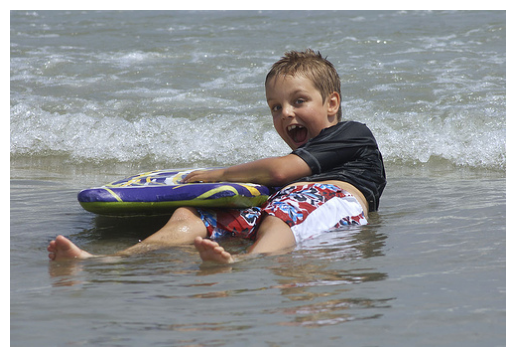

BLEU-1: 0.6667, BLEU-2: 0.4082
----------
Image: 369047365_35476becc9
Actual Caption: ['startseq couple enjoying the high plains with their dogs endseq', 'startseq man is taking photo of another man and his two dogs on some grassy hills endseq', 'startseq dog training on the mountain endseq', 'startseq the man wearing the white shirt takes picture of the man in the blue shirt with the two dogs endseq', 'startseq two men take hike with two dogs endseq']
Generated Caption: a hill


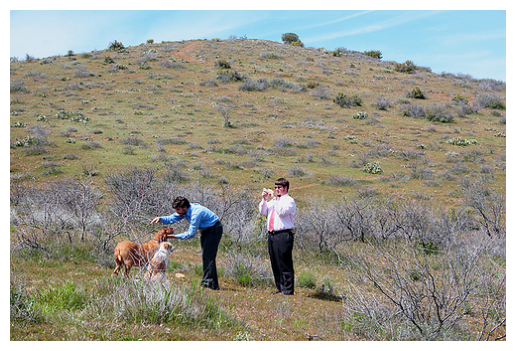

BLEU-1: 0.0000, BLEU-2: 0.0000
----------
Image: 3631023049_8a85bab19f
Actual Caption: ['startseq the children are on tire swing endseq', 'startseq three children play in large bowl shaped swing endseq', 'startseq three children ride on round swing while another watches from the grass endseq', 'startseq three children riding on large swing endseq', 'startseq three smiling children swing in tire swing at playground endseq']
Generated Caption: a red metal frame


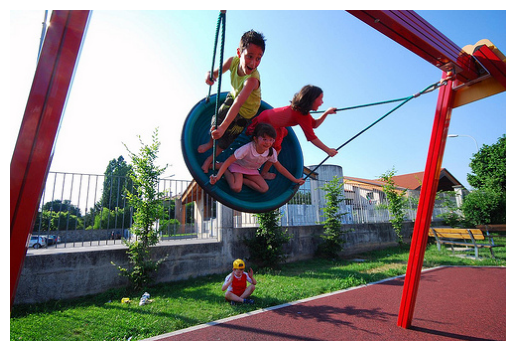

BLEU-1: 0.0000, BLEU-2: 0.0000
----------
Image: 236095031_5cb17dc54a
Actual Caption: ['startseq boy rock climbs endseq', 'startseq man is rock climbing without shirt endseq', 'startseq young boy rock climbing endseq', 'startseq the boy looked down as he climbed the steep rock face endseq', 'startseq the climber is hanging off vertical cliff with gear but no shirt endseq']
Generated Caption: a man climbing up a rock face


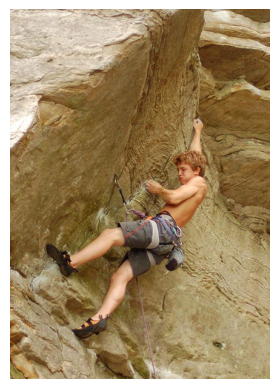

BLEU-1: 0.5714, BLEU-2: 0.3086
----------
Average BLEU-1 Score: 0.2641
Average BLEU-2 Score: 0.1194


In [41]:
import os
import random
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# Load BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


# Define smoothing function to avoid BLEU zero-scores
smooth_fn = SmoothingFunction().method1

# Load captions and select random images
# captions = load_captions('/kaggle/input/flickr8k/captions.txt')

random_images = random.sample(list(mapping.keys()), 10)  # Adjust the number of samples

# Store BLEU scores
bleu1_scores = []
bleu2_scores = []

for img_name in random_images:
    # Load and process the image
    image_path = os.path.join(BASE_DIR,'Images', f"{img_name}.jpg")
    image = Image.open(image_path)
    inputs = processor(image, return_tensors="pt")


    # Generate caption using BLIP
    output = model.generate(**inputs)
    generated_caption = processor.decode(output[0], skip_special_tokens=True)

    # Display the image and generated caption
    print(f"Image: {img_name}")
    print(f"Actual Caption: {mapping[img_name]}")
    print(f"Generated Caption: {generated_caption}")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Tokenize reference and generated captions
    ref_tokens = [cap.split() for cap in mapping[img_name]]
    gen_tokens = generated_caption.split()

    # Compute BLEU-1 and BLEU-2 scores
    bleu1 = sentence_bleu(ref_tokens, gen_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
    bleu2 = sentence_bleu(ref_tokens, gen_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)

    # Store and print the BLEU scores
    bleu1_scores.append(bleu1)
    bleu2_scores.append(bleu2)
    print(f"BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}")
    print('----------')

# Calculate and print average BLEU scores
print(f"Average BLEU-1 Score: {sum(bleu1_scores) / len(bleu1_scores):.4f}")
print(f"Average BLEU-2 Score: {sum(bleu2_scores) / len(bleu2_scores):.4f}")


<div style = 'border : 3px solid #cde3ea; background-color:#cde3ea;padding:10px; border-radius: 25px;'>



🔘 **Summary and conclusion**

    

   - **Feature Extraction Importance** : The success of the image captioning model heavily relies on effectively extracting essential features from images. By utilizing advanced pre-trained models for feature extraction, we can significantly enhance the model’s ability to understand visual content.

    

    

    

   - **Text Processing Impact** : Careful preprocessing of captions is crucial for improving model performance. Techniques such as tokenization, cleaning, and embedding help create meaningful representations of text that contribute to more accurate caption generation.

    

   - **Model Complexity and Performance** : While increasing the complexity of the model, such as incorporating bidirectional RNNs or attention mechanisms, can lead to improved accuracy, it also requires longer training times. Balancing complexity and computational efficiency is key for practical applications.

    

   - **Benefits of Pre-trained Models** : Leveraging pre-trained models is highly beneficial, as they bring in knowledge learned from vast datasets. This transfer learning approach results in quicker convergence and improved performance on specific tasks like image captioning. 